<a href="https://colab.research.google.com/github/alban12/llm-itu/blob/main/artifacts/Falcon_LLM_ITU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Falcon LLM for [ITU TelCo MCQA Challenge](https://zindi.africa/competitions/specializing-large-language-models-for-telecom-networks)

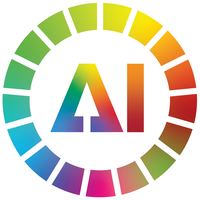

*Abstract* - In this notebook, we will explore different strategies to improve the Falcon 7B model and make it effective enough to have a good score on MCQAs tasks specialized in the TelCo industry. We will first apply some grounding techniques with Retrieval Augmented Generation using standards provided. We will further improve our performances by using some Prompt Engineering technique and we will show how they compare against each other. Finally, we will conclude on the strategies for solving this kind of task.

## 0. Installations and Imports

### Installations

For Falcon model retrieval

*   transformers  
*   Élément de liste

In [27]:
!pip install transformers datasets evaluate accelerate
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 M


For RAG

*   Langchain

In [1]:
!pip install bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.6/983.6 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.1/366.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 30.9 MB/s eta 0:00:00
INFO: pip is looking 

In [8]:
!pip install langchain-huggingface

In [1]:
!pip install gsutil

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.1/178.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gsutil: filename=gsutil-5.30-py3-none-any.whl size=3789296 sha256=60498e14a27d7be77adc3ce8ed8facc6cea81105ad370f5f976c5533a0db1de4
  Stored in directory: /root/.cache/pip/wheels/07/86/e4/c4e987141d5e703a27d95f37a45

### Libraries imports

In [9]:
# Viz
import pandas as pd

# Using the model
from transformers import pipeline, AutoTokenizer, AutoModelForQuestionAnswering
import transformers
import torch
from langchain_huggingface import HuggingFacePipeline

# Importing data
import json
from datasets import Dataset
from google.colab import auth
auth.authenticate_user()

# RAG


# Eval

### Data imports

In [20]:
from google.colab import auth
auth.authenticate_user()

In [23]:
# Importing the data
!gsutil cp gs://llm-itu-data/Q_A_ID_training.csv .
!gsutil cp gs://llm-itu-data/SampleSubmission.csv .
!gsutil cp gs://llm-itu-data/TeleQnA_testing1.txt .
!gsutil cp gs://llm-itu-data/TeleQnA_training.txt .
!gsutil cp gs://llm-itu-data/questions_new.txt .
!gsutil cp gs://llm-itu-data/rel18.rar .

Copying gs://llm-itu-data/Q_A_ID_training.csv...
- [1 files][ 19.8 KiB/ 19.8 KiB]                                                
Operation completed over 1 objects/19.8 KiB.                                     
Copying gs://llm-itu-data/SampleSubmission.csv...
- [1 files][ 20.5 KiB/ 20.5 KiB]                                                
Operation completed over 1 objects/20.5 KiB.                                     
Copying gs://llm-itu-data/TeleQnA_testing1.txt...
- [1 files][177.5 KiB/177.5 KiB]                                                
Operation completed over 1 objects/177.5 KiB.                                    
Copying gs://llm-itu-data/TeleQnA_training.txt...
- [1 files][  1.0 MiB/  1.0 MiB]                                                
Operation completed over 1 objects/1.0 MiB.                                      
Copying gs://llm-itu-data/questions_new.txt...
- [1 files][867.7 KiB/867.7 KiB]                                                
Operation completed o

In [24]:
!unrar x rel18.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from rel18.rar

Creating    rel18                                                     OK
Extracting  rel18/21900-i10.docx                                           0%  OK 
Extracting  rel18/22011-i50.docx                                           0%  OK 
Extracting  rel18/22101-i50.docx                                           0%  OK 
Extracting  rel18/22104-i30.docx                                           0%  OK 
Extracting  rel18/22115-i00.docx                                           0%  OK 
Extracting  rel18/22125-i00.docx                                           0%  OK 
Extracting  rel18/22153-i20.docx                                           0%  OK 
Extracting  rel18/22179-i00.docx                                           0%  OK 
Extracting  rel18/22261-ic0.docx                                           0%  

In [2]:
# Features
category = []
explanation = []
answers = []
question_and_options = []

In [5]:
with open('TeleQnA_training.txt') as f:
    json_data = json.load(f)

for key in json_data.keys():
  category.append(json_data[key].pop("category"))
  explanation.append(json_data[key].pop("explanation"))
  answers.append(json_data[key].pop("answer"))
  question_and_options.append(json_data[key])
my_dict = {"question_and_options": question_and_options,
           "category": category,
           "explanation": explanation,
           "answers": answers}
dataset = Dataset.from_dict(my_dict)

#### Samples

In [6]:
pd.read_csv("SampleSubmission.csv")

,Question_ID,Answer_ID
0,8138,0
1,8153,0
2,8156,0
3,8160,0
4,8165,0
...,...,...
2362,11996,0
2363,11997,0
2364,11998,0
2365,11999,0


## 1. Model initialization

## Parameters config

In [2]:
model_id = "tiiuae/falcon-7b"

In [ ]:
from langchain_huggingface.llms import HuggingFacePipeline

hf = HuggingFacePipeline.from_model_id(
    model_id=model_id,
    task="text-generation",
    pipeline_kwargs={"max_new_tokens": 10},
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Pipeline creation

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

# model = AutoModelForCausalLM.from_pretrained(model_id)
pipe = pipeline("question-answering", model=model_id, tokenizer=tokenizer, torch_dtype=torch.bfloat16, device_map="auto")
hf = HuggingFacePipeline(pipeline=pipe)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

ValueError: Could not load model tiiuae/falcon-7b with any of the following classes: (<class 'transformers.models.auto.modeling_auto.AutoModelForQuestionAnswering'>, <class 'transformers.models.auto.modeling_tf_auto.TFAutoModelForQuestionAnswering'>, <class 'transformers.models.falcon.modeling_falcon.FalconForCausalLM'>). See the original errors:

while loading with AutoModelForQuestionAnswering, an error is thrown:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py", line 283, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py", line 563, in from_pretrained
    return model_class.from_pretrained(
  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py", line 3754, in from_pretrained
    ) = cls._load_pretrained_model(
  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py", line 3877, in _load_pretrained_model
    raise ValueError(
ValueError: The current `device_map` had weights offloaded to the disk. Please provide an `offload_folder` for them. Alternatively, make sure you have `safetensors` installed if the model you are using offers the weights in this format.

while loading with TFAutoModelForQuestionAnswering, an error is thrown:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py", line 283, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py", line 566, in from_pretrained
    raise ValueError(
ValueError: Unrecognized configuration class <class 'transformers.models.falcon.configuration_falcon.FalconConfig'> for this kind of AutoModel: TFAutoModelForQuestionAnswering.
Model type should be one of AlbertConfig, BertConfig, CamembertConfig, ConvBertConfig, DebertaConfig, DebertaV2Config, DistilBertConfig, ElectraConfig, FlaubertConfig, FunnelConfig, GPTJConfig, LayoutLMv3Config, LongformerConfig, MobileBertConfig, MPNetConfig, RemBertConfig, RobertaConfig, RobertaPreLayerNormConfig, RoFormerConfig, XLMConfig, XLMRobertaConfig, XLNetConfig.

while loading with FalconForCausalLM, an error is thrown:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py", line 283, in infer_framework_load_model
    model = model_class.from_pretrained(model, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py", line 3754, in from_pretrained
    ) = cls._load_pretrained_model(
  File "/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py", line 3877, in _load_pretrained_model
    raise ValueError(
ValueError: The current `device_map` had weights offloaded to the disk. Please provide an `offload_folder` for them. Alternatively, make sure you have `safetensors` installed if the model you are using offers the weights in this format.




In [ ]:
from langchain_core.prompts import PromptTemplate

template = """Question: {question}

Answer: Let's think step by step."""

prompt = PromptTemplate.from_template(template)

chain = prompt | hf

question = "What is electroencephalography?"

print(chain.invoke({"question": question}))

In [ ]:


model = "tiiuae/falcon-7b"

tokenizer = AutoTokenizer.from_pretrained(model)

pipeline = transformers.pipeline(
    "question-answering",
    model=model,
    tokenizer=tokenizer,

    trust_remote_code=True,
    ,
)

sequences = pipeline(
   " TOMODIFY: Girafatron is obsessed with giraffes, the most glorious animal on the face of this Earth. Giraftron believes all other animals are irrelevant when compared to the glorious majesty of the giraffe.\nDaniel: Hello, Girafatron!\nGirafatron:",
    max_length=200,
    do_sample=True,
    top_k=10,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
)
for seq in sequences:
    print(f"Result: {seq['generated_text']}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

configuration_falcon.py:   0%|          | 0.00/7.16k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.



modeling_falcon.py:   0%|          | 0.00/56.9k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


Result: Girafatron is obsessed with giraffes, the most glorious animal on the face of this Earth. Giraftron believes all other animals are irrelevant when compared to the glorious majesty of the giraffe.
Daniel: Hello, Girafatron!
Girafatron: *Squeaky chirruping*
Daniel: *Chirruping back*
Girafatron: *Bark*
Daniel: *Bark*
Girafatron: *Bark*
Daniel: *Bark*
Girafatron: *Chirrup*
Daniel: *Bark*
Girafatron: *Bark*
Daniel: *Bark*
Girafatron: *Bark*
Daniel: *Chirrup*
Girafatron: *Chirrup*
Daniel: 


## 2. RAG

## 3. Prompt Engineering

## 4. Evaluation

## 5. Conclusion

## References